# Tutorial 11: Normalizing Flows for image modeling



In [12]:
## Standard libraries
import os
import math
import time
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
#DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
#CHECKPOINT_PATH = "../saved_models/tutorial11"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipykernel_2925613/3629559364.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
[rank: 0] Global seed set to 42


Using device cuda:0


In [13]:
#custom imports
from utils import load_graph_dataset, train, evaluate
from models import GIN, HeteroGIN

In [3]:
#IMPORT DATA
data_folder = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"
data_path = "/hpc/group/vossenlab/mfm45/.dgl/"
train_loader, val_loader, nclasses, nfeatures, nfeatures_edge = load_graph_dataset(dataset=data_folder, prefix=data_path, 
                                                    split=0.75, max_events=1e5, indices=None,
                                                    num_workers=0, batch_size=256)

In [8]:
log_pz_temp = torch.empty(16, 1, 8, 8)
print(log_pz_temp.size())
log_pz_dim = len(list(log_pz_temp.size()))
for i in range(log_pz_dim - 1):
    if(i == 0):
        log_pz = log_pz_temp.sum(dim=log_pz_dim - i - 1)
    else:
        log_pz = log_pz.sum(dim=log_pz_dim - i - 1)
print(log_pz.size())

torch.Size([16, 1, 8, 8])
log_pz_dim: 4
summing over dimension 3
summing over dimension 2
summing over dimension 1
torch.Size([16])


In [4]:
'''
NOTE:
    No longer using bpd, just nll as we assume that all inputs will have the same dimension as the
    samples. Also, generalized _get_likelihood to work on inputs of any dimension, not just 4D
    images which was the case before. Last change: removed importance sampling as it didn't seem applicable
'''
class GraphFlow(pl.LightningModule):
    
    def __init__(self, flows):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images. 
            REMOVED: import_samples - Number of importance samples to use during testing (see explanation below). Can be changed at any time
        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)

    def forward(self, graphs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(graphs)

    def encode(self, graphs):
        # Given a batch of graphs, return the latent representation z and ldj of the transformations
        z, ldj = graphs, torch.zeros(graphs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, graphs, return_ll=False):
        """
        Given a batch of graphs, return the likelihood of those. 
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        #get latent repr
        z, ldj = self.encode(graphs)
        
        #calculate log prob over entire latent space
        log_pz_temp = self.prior.log_prob(z)
        
        #reduce dimension down to 1D
        log_pz_dim = len(list(log_pz_temp.size()))
        for i in range(log_pz_dim - 1):
            if(i == 0):
                log_pz = log_pz_temp.sum(dim=log_pz_dim - i - 1)
            else:
                log_pz = log_pz.sum(dim=log_pz_dim - i - 1)
        
        #add det of jacobian and log prob to get negative log likelihood
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        #bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        #return bpd.mean() if not return_ll else log_px
        '''
        Replaced bpd with nll
        '''
        return nll

    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)
        
        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])                             
        self.log('train_nll', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log('val_nll', loss)

    def test_step(self, batch, batch_idx):
        '''
        Replaced bpd with nll
        '''
        #NO IMPORTANCE SAMPLING
        img_ll = self._get_likelihood(batch[0], return_ll=True)
        
        # Calculate final bpd
#         bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
#         bpd = bpd.mean()
        nll = -img_ll
        
        self.log('test_nll', nll)

In [5]:
class CouplingLayer(nn.Module):
    
    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter, 
        # but should be part of the modules state.
        self.register_buffer('mask', mask)
    
    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows. 
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)
        
        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac
        
        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        
        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])
            
        return z, ldj

In [6]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask

def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in//2, dtype=torch.float32), 
                      torch.zeros(c_in-c_in//2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

In [7]:
checkerboard_mask = create_checkerboard_mask(h=8, w=8).expand(-1,2,-1,-1)
channel_mask = create_channel_mask(c_in=2).expand(-1,-1,8,8)

In [8]:
class ConcatELU(nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain). 
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """
    
    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)

    
class LayerNormChannels(nn.Module):
    
    def __init__(self, c_in, eps=1e-5):
        """
        This module applies layer norm across channels in an image.
        Inputs: 
            c_in - Number of channels of the input
            eps - Small constant to stabilize std
        """
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y

    
class GatedConv(nn.Module):
    
    def __init__(self, c_in, c_hidden):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )
    
    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)

    
class GatedConvNet(nn.Module):
    
    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden),
                       LayerNormChannels(c_hidden)]
        layers += [ConcatELU(),
                   nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)
        
        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()
    
    def forward(self, x):
        return self.nn(x)

In [9]:
def create_simple_flow():
    flow_layers = []
    for i in range(8):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                      mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                      c_in=1)]
        
    flow_model = GraphFlow(flow_layers).to(device)
    return flow_model

For implementing the training loop, we use the framework of PyTorch Lightning and reduce the code overhead. If interested, you can take a look at the generated tensorboard file, in particularly the graph to see an overview of flow transformations that are applied. Note that we again provide pre-trained models (see later on in the notebook) as normalizing flows are particularly expensive to train. We have also run validation and testing as this can take some time as well with the added importance sampling.

In [10]:
#NEED TO ADJUST FILE PATHS AND SUCH
def train_flow(flow, train_loader, val_loader, model_name="MNISTFlow"):
    # Create a PyTorch Lightning trainer
    CHECKPOINT_PATH = "NF_checkpoints"
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_name), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=200, 
                         gradient_clip_val=1.0,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=5)
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    #NEED TO SETUP TRAINING, VALIDATION, AND TESTING DATA - these loaders are created in first cell using load_graph_dataset
#     train_data_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
#     val_loader = data.DataLoader(val_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
#     test_loader = data.DataLoader(test_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
    result = None
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename, map_location=device)
        flow.load_state_dict(ckpt['state_dict'])
        result = ckpt.get("result", None)
    else:
        print("Start training", model_name)
        trainer.fit(flow, train_loader, val_loader)
    
    # Test best model on validation and test set if no result has been found
    # Testing can be expensive due to the importance sampling.
    if result is None:
        start_time = time.time()
        val_result = trainer.test(flow, val_loader, verbose=False)
        duration = time.time() - start_time
        result = {"val": val_result, "time": duration / len(test_loader) / flow.import_samples}
    
    return flow, result

In [11]:
class SqueezeFlow(nn.Module):
    
    def forward(self, z, ldj, reverse=False):
        B, C, H, W = z.shape
        if not reverse: 
            # Forward direction: H x W x C => H/2 x W/2 x 4C
            z = z.reshape(B, C, H//2, 2, W//2, 2)
            z = z.permute(0, 1, 3, 5, 2, 4)
            z = z.reshape(B, 4*C, H//2, W//2)
        else: 
            # Reverse direction: H/2 x W/2 x 4C => H x W x C
            z = z.reshape(B, C//4, 2, 2, H, W)
            z = z.permute(0, 1, 4, 2, 5, 3)
            z = z.reshape(B, C//4, H*2, W*2)
        return z, ldj

Before moving on, we can verify our implementation by comparing our output with the example figure above:

The split operation divides the input into two parts, and evaluates one part directly on the prior. So that our flow operation fits to the implementation of the previous layers, we will return the prior probability of the first part as the log determinant jacobian of the layer. It has the same effect as if we would combine all variable splits at the end of the flow, and evaluate them together on the prior. 

In [12]:
class SplitFlow(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
    
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, z_split = z.chunk(2, dim=1)
            ldj += self.prior.log_prob(z_split).sum(dim=[1,2,3])
        else:
            z_split = self.prior.sample(sample_shape=z.shape).to(device)
            z = torch.cat([z, z_split], dim=1)
            ldj -= self.prior.log_prob(z_split).sum(dim=[1,2,3])
        return z, ldj

In [13]:
def create_multiscale_flow():
    flow_layers = []
    
    flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                  mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                  c_in=1) for i in range(2)]
    flow_layers += [SqueezeFlow()]
    for i in range(2):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=4, c_hidden=48),
                                      mask=create_channel_mask(c_in=4, invert=(i%2==1)),
                                      c_in=4)]
    flow_layers += [SplitFlow(),
                    SqueezeFlow()]
    for i in range(4):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=8, c_hidden=64),
                                      mask=create_channel_mask(c_in=8, invert=(i%2==1)),
                                      c_in=8)]

    flow_model = GraphFlow(flow_layers).to(device)
    return flow_model

We can show the difference in number of parameters below:

In [14]:
def print_num_params(model):
    num_params = sum([np.prod(p.shape) for p in model.parameters()])
    print("Number of parameters: {:,}".format(num_params))

print_num_params(create_simple_flow())
print_num_params(create_multiscale_flow())

Number of parameters: 556,312
Number of parameters: 1,639,742


Although the multi-scale flow has almost 3 times the parameters of the single scale flow, it is not necessarily more computationally expensive than its counterpart. We will compare the runtime in the following experiments as well. 

## Analysing the flows

In the last part of the notebook, we will train all the models we have implemented above, and try to analyze the effect of the multi-scale architecture and variational dequantization.

### Training flow variants

Before we can analyse the flow models, we need to train them first. We provide pre-trained models that contain the validation and test performance, and run-time information. As flow models are computationally expensive, we advice you to rely on those pretrained models for a first run through the notebook.

In [33]:
flow_dict = {"simple": {}, "multiscale": {}}
flow_dict["simple"]["model"], flow_dict["simple"]["result"] = train_flow(create_simple_flow(), train_loader, val_loader,model_name="graph_Flow_6_12")
flow_dict["multiscale"]["model"], flow_dict["multiscale"]["result"] = train_flow(create_multiscale_flow(), train_loader, val_loadermodel_name="graph_Flow_6_12")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Start training graph_Flow_6_12


You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | flows | ModuleList | 556 K 
-------------------------------------
556 K     Trainable params
0         Non-trainable params
556 K     Total params
2.225     Total estimated model params size (MB)
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/pytorch_lightning/loggers/tensorboard.py:190: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
  rank_zero_warn(
2023-06-12 16:36:32.512274: I tensorflow/

Sanity Checking: 0it [00:00, ?it/s]

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 11 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


AttributeError: 'DGLGraph' object has no attribute 'shape'

In [24]:
flow_dict["simple"]["result"]

{'test': [{'test_bpd': 1.07839834690094}],
 'val': [{'test_bpd': 1.0798484086990356}],
 'time': 0.019570968523147,
 'samp_time': 0.017716965675354003}

### Density modeling and sampling

Firstly, we can compare the models on their quantitative results. The following table shows all important statistics. The inference time specifies the time needed to determine the probability for a batch of 64 images for each model, and the sampling time the duration it took to sample a batch of 64 images.

In [25]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [26]:
import tabulate
from IPython.display import display, HTML

table = [[key, 
          "%4.3f bpd" % flow_dict[key]["result"]["val"][0]["test_bpd"], 
          "%4.3f bpd" % flow_dict[key]["result"]["test"][0]["test_bpd"], 
          "%2.0f ms" % (1000 * flow_dict[key]["result"]["time"]),
          "%2.0f ms" % (1000 * flow_dict[key]["result"].get("samp_time", 0)),
          "{:,}".format(sum([np.prod(p.shape) for p in flow_dict[key]["model"].parameters()]))] 
         for key in flow_dict]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Validation Bpd", "Test Bpd", "Inference time", "Sampling time", "Num Parameters"])))

Model,Validation Bpd,Test Bpd,Inference time,Sampling time,Num Parameters
simple,1.080 bpd,1.078 bpd,20 ms,18 ms,"556,312"
vardeq,1.045 bpd,1.043 bpd,26 ms,18 ms,"628,388"
multiscale,1.022 bpd,1.020 bpd,23 ms,15 ms,"1,711,818"


As we have intially expected, using variational dequantization improves upon standard dequantization in terms of bits per dimension. Although the difference with 0.04bpd doesn't seem impressive first, it is a considerably step for generative models (most state-of-the-art models improve upon previous models in a range of 0.02-0.1bpd on CIFAR with three times as high bpd). While it takes longer to evaluate the probability of an image due to the variational dequantization, which also leads to a longer training time, it does not have an effect on the sampling time. This is because inverting variational dequantization is the same as dequantization: finding the next lower integer.

When we compare the two models to multi-scale architecture, we can see that the bits per dimension score again dropped by about 0.02bpd. Additionally, the sampling time improved notably despite having more parameters. Thus, we see that the multi-scale flow is not only stronger for density modeling, but also more efficient. 

Next, we can test the sampling quality of the models. We should note that the samples for variational dequantization and standard dequantization are very similar, and hence we visualize here only the ones for variational dequantization and the multi-scale model. However, feel free to also test out the `"simple"` model. The seeds are set to obtain reproducable generations and are not cherry picked.

Global seed set to 44


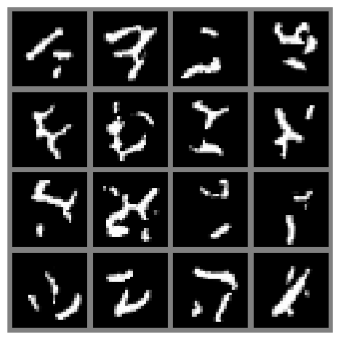

In [27]:
pl.seed_everything(44)
samples = flow_dict["vardeq"]["model"].sample(img_shape=[16,1,28,28])
show_imgs(samples.cpu())

Global seed set to 42


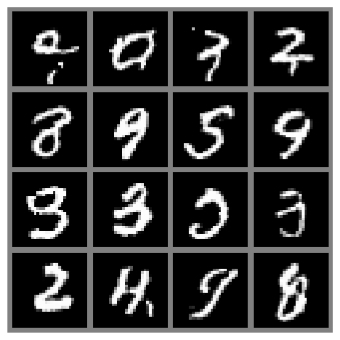

In [28]:
pl.seed_everything(42)
samples = flow_dict["multiscale"]["model"].sample(img_shape=[16,8,7,7])
show_imgs(samples.cpu())

From the few samples, we can see a clear difference between the simple and the multi-scale model. The single-scale model has only learned local, small correlations while the multi-scale model was able to learn full, global relations that form digits. This show-cases another benefit of the multi-scale model. In contrast to VAEs, the outputs are sharp as normalizing flows can naturally model complex, multi-modal distributions while VAEs have the independent decoder output noise. Nevertheless, the samples from this flow are far from perfect as not all samples show true digits. 

### Interpolation in latent space

Another popular test for the smoothness of the latent space of generative models is to interpolate between two training examples. As normalizing flows are strictly invertible, we can guarantee that any image is represented in the latent space. We again compare the variational dequantization model with the multi-scale model below.

In [29]:
@torch.no_grad()
def interpolate(model, img1, img2, num_steps=8):
    """
    Inputs:
        model - object of GraphFlow class that represents the (trained) flow model
        img1, img2 - Image tensors of shape [1, 28, 28]. Images between which should be interpolated.
        num_steps - Number of interpolation steps. 8 interpolation steps mean 6 intermediate pictures besides img1 and img2
    """
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    z, _ = model.encode(imgs)
    alpha = torch.linspace(0, 1, steps=num_steps, device=z.device).view(-1, 1, 1, 1)
    interpolations = z[0:1] * alpha + z[1:2] * (1 - alpha)
    interp_imgs = model.sample(interpolations.shape[:1] + imgs.shape[1:], z_init=interpolations)
    show_imgs(interp_imgs, row_size=8)

exmp_imgs, _ = next(iter(train_loader))

Global seed set to 42


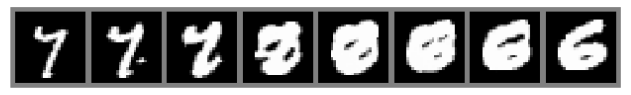

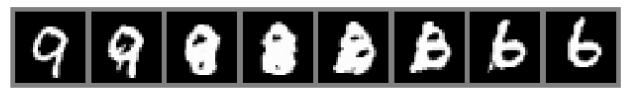

In [30]:
pl.seed_everything(42)
for i in range(2):
    interpolate(flow_dict["vardeq"]["model"], exmp_imgs[2*i], exmp_imgs[2*i+1])

Global seed set to 42


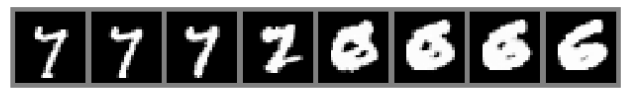

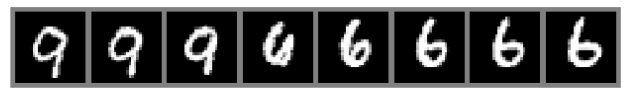

In [31]:
pl.seed_everything(42)
for i in range(2):
    interpolate(flow_dict["multiscale"]["model"], exmp_imgs[2*i], exmp_imgs[2*i+1])

The interpolations of the multi-scale model result in more realistic digits (first row $7\leftrightarrow 8\leftrightarrow 6$, second row $9\leftrightarrow 6$), while the variational dequantization model focuses on local patterns that globally do not form a digit. For the multi-scale model, we actually did not do the "true" interpolation between the two images as we did not consider the variables that were split along the flow (they have been sampled randomly for all samples). However, as we will see in the next experiment, the early variables do not effect the overall image much.

### Visualization of latents in different levels of multi-scale

In the following we will focus more on the multi-scale flow. We want to analyse what information is being stored in the variables split at early layers, and what information for the final variables. For this, we sample 8 images where each of them share the same final latent variables, but differ in the other part of the latent variables. Below we visualize three examples of this:

Global seed set to 44


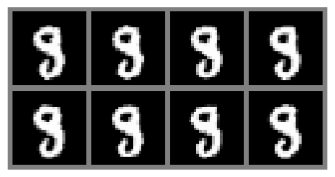

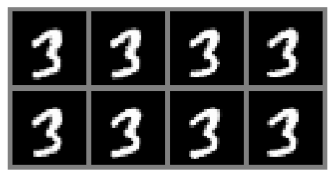

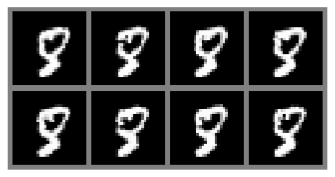

In [32]:
pl.seed_everything(44)
for _ in range(3):
    z_init = flow_dict["multiscale"]["model"].prior.sample(sample_shape=[1,8,7,7])
    z_init = z_init.expand(8, -1, -1, -1)
    samples = flow_dict["multiscale"]["model"].sample(img_shape=z_init.shape, z_init=z_init)
    show_imgs(samples.cpu())

We see that the early split variables indeed have a smaller effect on the image. Still, small differences can be spot when we look carefully at the borders of the digits. For instance, in the middle, the top part of the 3 has different thicknesses for different samples although all of them represent the same coarse structure. This shows that the flow indeed learns to separate the higher-level information in the final variables, while the early split ones contain local noise patterns.

### Visualizing Dequantization

As a final part of this notebook, we will look at the effect of variational dequantization. We have motivated variational dequantization by the issue of sharp edges/boarders being difficult to model, and a flow would rather prefer smooth, prior-like distributions. To check how what noise distribution $q(u|x)$ the flows in the variational dequantization module have learned, we can plot a histogram of output values from the dequantization and variational dequantization module. 

In [33]:
def visualize_dequant_distribution(model : GraphFlow, imgs : torch.Tensor, title:str=None):
    """
    Inputs:
        model - The flow of which we want to visualize the dequantization distribution
        imgs - Example training images of which we want to visualize the dequantization distribution 
    """
    imgs = imgs.to(device)
    ldj = torch.zeros(imgs.shape[0], dtype=torch.float32).to(device)
    with torch.no_grad():
        dequant_vals = []
        for _ in tqdm(range(8), leave=False):
            d, _ = model.flows[0](imgs, ldj, reverse=False)
            dequant_vals.append(d)
        dequant_vals = torch.cat(dequant_vals, dim=0)
    dequant_vals = dequant_vals.view(-1).cpu().numpy()
    sns.set()
    plt.figure(figsize=(10,3))
    plt.hist(dequant_vals, bins=256, color=to_rgb("C0")+(0.5,), edgecolor="C0", density=True)
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()
    
sample_imgs, _ = next(iter(train_loader))

  0%|          | 0/8 [00:00<?, ?it/s]

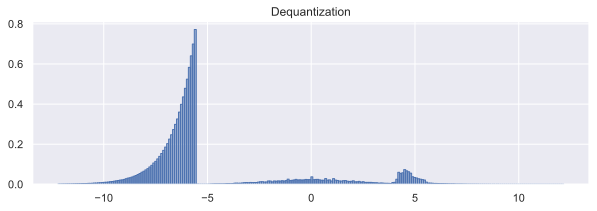

In [34]:
visualize_dequant_distribution(flow_dict["simple"]["model"], sample_imgs, title="Dequantization")

  0%|          | 0/8 [00:00<?, ?it/s]

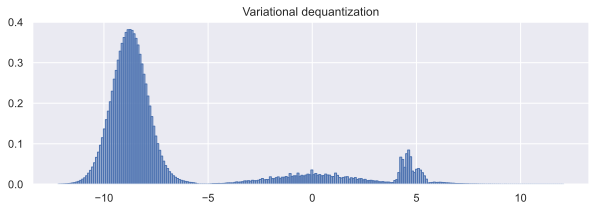

In [35]:
visualize_dequant_distribution(flow_dict["vardeq"]["model"], sample_imgs, title="Variational dequantization")

The dequantization distribution in the first plot shows that the MNIST images have a strong bias towards 0 (black), and the distribution of them have a sharp border as mentioned before. The variational dequantization module has indeed learned a much smoother distribution with a Gaussian-like curve which can be modeled much better. For the other values, we would need to visualize the distribution $q(u|x)$ on a deeper level, depending on $x$. However, as all $u$'s interact and depend on each other, we would need to visualize a distribution in 784 dimensions, which is not that intuitive anymore.

## Conclusion

In conclusion, we have seen how to implement our own normalizing flow, and what difficulties arise if we want to apply them on images. Dequantization is a crucial step in mapping the discrete images into continuous space to prevent underisable delta-peak solutions. While dequantization creates hypercubes with hard border, variational dequantization allows us to fit a flow much better on the data. This allows us to obtain a lower bits per dimension score, while not affecting the sampling speed. The most common flow element, the coupling layer, is simple to implement, and yet effective. Furthermore, multi-scale architectures help to capture the global image context while allowing us to efficiently scale up the flow. Normalizing flows are an interesting alternative to VAEs as they allow an exact likelihood estimate in continuous space, and we have the guarantee that every possible input $x$ has a corresponding latent vector $z$. However, even beyond continuous inputs and images, flows can be applied and allow us to exploit the data structure in latent space, as e.g. on graphs for the task of molecule generation [6]. Recent advances in [Neural ODEs](https://arxiv.org/pdf/1806.07366.pdf) allow a flow with infinite number of layers, called Continuous Normalizing Flows, whose potential is yet to fully explore. Overall, normalizing flows are an exciting research area which will continue over the next couple of years.

## References

[1] Dinh, L., Sohl-Dickstein, J., and Bengio, S. (2017). “Density estimation using Real NVP,” In: 5th International Conference on Learning Representations, ICLR 2017. [Link](https://arxiv.org/abs/1605.08803)

[2] Kingma, D. P., and Dhariwal, P. (2018). “Glow: Generative Flow with Invertible 1x1 Convolutions,” In: Advances in Neural Information Processing Systems, vol. 31, pp. 10215--10224. [Link](http://papers.nips.cc/paper/8224-glow-generative-flow-with-invertible-1x1-convolutions.pdf)

[3] Ho, J., Chen, X., Srinivas, A., Duan, Y., and Abbeel, P. (2019). “Flow++: Improving Flow-Based Generative Models with Variational Dequantization and Architecture Design,” in Proceedings of the 36th International Conference on Machine Learning, vol. 97, pp. 2722–2730. [Link](https://arxiv.org/abs/1902.00275)

[4] Durkan, C., Bekasov, A., Murray, I., and Papamakarios, G. (2019). “Neural Spline Flows,” In: Advances in Neural Information Processing Systems, pp. 7509–7520. [Link](http://papers.neurips.cc/paper/8969-neural-spline-flows.pdf)

[5] Hoogeboom, E., Cohen, T. S., and Tomczak, J. M. (2020). “Learning Discrete Distributions by Dequantization,” arXiv preprint arXiv2001.11235v1. [Link](https://arxiv.org/abs/2001.11235)

[6] Lippe, P., and Gavves, E. (2021). “Categorical Normalizing Flows via Continuous Transformations,” In: International Conference on Learning Representations, ICLR 2021. [Link](https://openreview.net/pdf?id=-GLNZeVDuik)

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---

In [31]:
t = torch.empty(2,1,28,28)
nt = t.sum(dim=[1,2,3])

In [36]:
print(t.sum(dim=3))

tensor([[[3.3071e+00, 9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45,
          9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45,
          9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45,
          9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45,
          9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45,
          9.8091e-45, 9.8091e-45, 9.8091e-45]],

        [[9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45,
          9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45,
          9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45,
          9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45,
          9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45, 9.8091e-45,
          9.8091e-45, 9.8091e-45, 9.8091e-45]]])


In [33]:
print(len(list(t.size())))

4


In [29]:
print(len(list(nt.size())))

1
